In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
!ls Dataset2/MURA-v1.1/

train			  train_labeled_studies.csv  valid_image_paths.csv
train_elbow_negative.csv  valid			     valid_labeled_studies.csv
train_elbow_positive.csv  valid_elbow_negative.csv
train_image_paths.csv	  valid_elbow_positive.csv


In [4]:
PATH = 'Dataset2/MURA-v1.1/'

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')

##############
#cat = positive
#dog = negative
##############

In [6]:
train_cats_dir = os.path.join(train_dir, 'elbow_positive')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'elbow_negative')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'elbow_positive')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'elbow_negative')  # directory with our validation dog pictures

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 2006
total training dog images: 2925
total validation cat images: 230
total validation dog images: 235
--
Total training images: 4931
Total validation images: 465


In [33]:
batch_size = 128
epochs = 1
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [10]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [26]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 4931 images belonging to 2 classes.


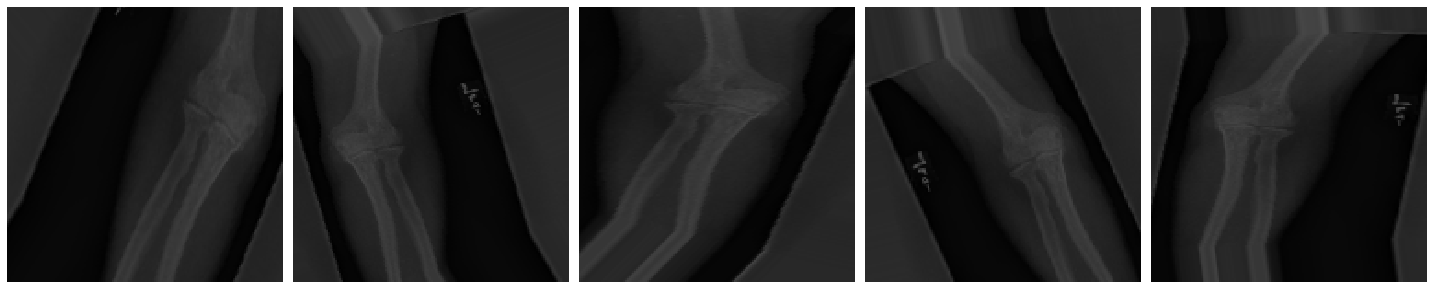

In [27]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [28]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 465 images belonging to 2 classes.


In [13]:
sample_training_images, _ = next(train_data_gen)

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

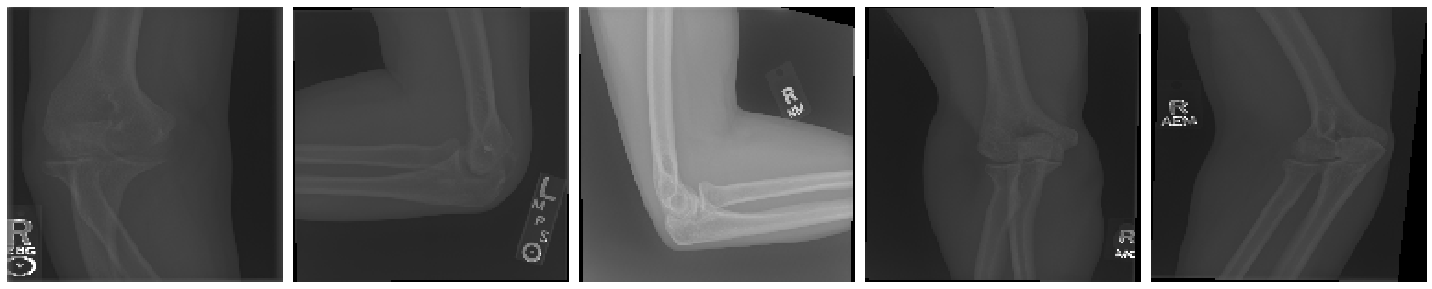

In [15]:
plotImages(sample_training_images[:5])

In [46]:
# model_new = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', 
#            input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(512, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
# ])
model = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT, IMG_WIDTH,3),
                                               include_top=False,
                                               weights='imagenet')

NameError: name 'layers' is not defined

In [42]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [43]:
model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block2_2_conv (Conv2D)    (None, 4, 4, 32)     36864       conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_concat (Concatenat (None, 4, 4, 704)    0           conv5_block1_concat[0][0]        
                                                                 conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_0_bn (BatchNormali (None, 4, 4, 704)    2816        conv5_block2_concat[0][0]        
__________________________________________________________________________________________________
conv5_block3_0_relu (Activation (None, 4, 4, 704)    0           conv5_block3_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_1_conv (Conv2D)    (None, 4, 4, 128)    90112       conv5_block3_0_relu[0][0]        
__________

In [44]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

ValueError: A target array with shape (128, 1) was passed for an output of shape (None, 4, 4, 1664) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

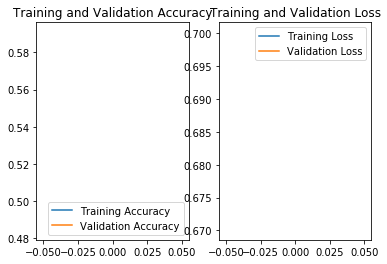

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()